# 1. Import libraries

In [155]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Load raw data

In [2]:
# Create Spark session
spark = SparkSession.builder.appName('transactions').getOrCreate()

# Read JSON file
input_df = spark.read.json('/kaggle/input/cc-sample-data/cc_sample_transaction.json')

## 2.1 Method
- Display the first few rows of the raw data.
- Check the schema of the raw data.
- Check the size of the raw data.

In [3]:
# Set global option for pandas dataframe
pd.set_option('display.max_colwidth', None)  # show full column values
pd.set_option('display.max_columns', None)  # show all columns

# Get a preview of the raw data
input_df.limit(10).toPandas()

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,merch_zipcode,merchant,personal_detail,trans_date_trans_time,trans_num
0,0,4.97,misc_net,CITIUS33CHI,2703186189652095,0,1325376018798532,1325376018666,36.011293,-82.048315,28705,"fraud_Rippin, Kub and Mann","{""person_name"":""Jennifer,Banks,eeeee"",""gender"":""F"",""address"":""{\""street\"":\""561 Perry Cove\"",\""city\"":\""Moravian Falls\"",\""state\"":\""NC\"",\""zip\"":\""28654\""}"",""lat"":""36.0788"",""long"":""-81.1781"",""city_pop"":""3495"",""job"":""Psychologist, counselling"",""dob"":""1988-03-09""}",2019-01-01 00:00:18,0b242abb623afc578575680df30655b9
1,1,107.23,grocery_pos,ADMDUS41,630423337322,0,1325376044867960,132537604479,49.159046999999994,-118.186462,None,"fraud_Heller, Gutmann and Zieme","{""person_name"":""Stephanie,Gill,eeeee"",""gender"":""F"",""address"":""{\""street\"":\""43039 Riley Greens Suite 393\"",\""city\"":\""Orient\"",\""state\"":\""WA\"",\""zip\"":\""99160\""}"",""lat"":""48.8878"",""long"":""-118.2105"",""city_pop"":""149"",""job"":""Special educational needs teacher"",""dob"":""1978-06-21""}",2019-01-01 00:00:44,1f76529f8574734946361c461b024d99
2,2,220.11,entertainment,Null,38859492057661,0,1325376051506840,1325376051286,43.150704,-112.154481,83236,fraud_Lind-Buckridge,"{""person_name"":""Edward@Sanchez"",""gender"":""M"",""address"":""{\""street\"":\""594 White Dale Suite 530\"",\""city\"":\""Malad City\"",\""state\"":\""ID\"",\""zip\"":\""83252\""}"",""lat"":""42.1808"",""long"":""-112.262"",""city_pop"":""4154"",""job"":""Nature conservation officer"",""dob"":""1962-01-19""}",2019-01-01 00:00:51,a1a22d70485983eac12b5b88dad1cf95
3,3,45.0,gas_transport,DEUTUS33TRF,3534093764340240,0,1325376076794698,1325376076365,47.034331,-112.561071,None,"fraud_Kutch, Hermiston and Farrell","{""person_name"":""Jeremy/White, !"",""gender"":""M"",""address"":""{\""street\"":\""9443 Cynthia Court Apt. 038\"",\""city\"":\""Boulder\"",\""state\"":\""MT\"",\""zip\"":\""59632\""}"",""lat"":""46.2306"",""long"":""-112.1138"",""city_pop"":""1939"",""job"":""Patent attorney"",""dob"":""1967-01-12""}",2019-01-01 00:01:16,6b849c168bdad6f867558c3793159a81
4,4,41.96,misc_pos,APBCUS61,375534208663984,0,1325376186746376,132537618681,38.674999,-78.632459,22844,fraud_Keeling-Crist,"{""person_name"":""Tyler@Garcia"",""gender"":""M"",""address"":""{\""street\"":\""408 Bradley Rest\"",\""city\"":\""Doe Hill\"",\""state\"":\""VA\"",\""zip\"":\""24433\""}"",""lat"":""38.4207"",""long"":""-79.4629"",""city_pop"":""99"",""job"":""Dance movement psychotherapist"",""dob"":""1986-03-28""}",2019-01-01 00:03:06,a41d7549acf90789359a9aa5346dcb46
5,5,94.63,gas_transport,APBCUS61,4767265376804500,0,1325376248271406,1325376248483,40.653382,-76.15266700000001,17972,"fraud_Stroman, Hudson and Erdman","{""person_name"":""Jennifer,Conner,eeeee"",""gender"":""F"",""address"":""{\""street\"":\""4655 David Island\"",\""city\"":\""Dublin\"",\""state\"":\""PA\"",\""zip\"":\""18917\""}"",""lat"":""40.375"",""long"":""-75.2045"",""city_pop"":""2158"",""job"":""Transport planner"",""dob"":""1961-06-19""}",2019-01-01 00:04:08,189a841a0a8ba03058526bcfe566aab5
6,6,44.54,grocery_net,APBCUS61,30074693890476,0,1325376282274130,1325376282247,37.162704999999995,-100.15337,None,fraud_Rowe-Vandervort,"{""person_name"":""Kelsey, , Richards NOOOO"",""gender"":""F"",""address"":""{\""street\"":\""889 Sarah Station Suite 624\"",\""city\"":\""Holcomb\"",\""state\"":\""KS\"",\""zip\"":\""67851\""}"",""lat"":""37.9931"",""long"":""-100.9893"",""city_pop"":""2691"",""job"":""Arboriculturist"",""dob"":""1993-08-16""}",2019-01-01 00:04:42,83ec1cc84142af6e2acf10c44949e720
7,7,71.65,gas_transport,NA,6011360759745864,0,1325376308837349,1325376308152,38.948089,-78.540296,22644,fraud_Corwin-Collins,"{""person_name"":""Steven, Williams"",""gender"":""M"",""address"":""{\""street\"":\""231 Flores Pass Suite 720\"",\""city\"":\""Edinburg\"",\""state\"":\""VA\"",\""zip\

In [4]:
# Check schema of raw data
input_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [75]:
# Check size of raw data
print('Total rows:', input_df.count())
print('Total columns:', len(input_df.columns))

Total rows: 1296675
Total columns: 15


## 2.2 Finding
- All fields are in string data type and would need to be converted to their appropriate data types.
- The `personal_detail` JSON field and has a nested JSON subfield named `address` that has escape characters within.
- All fields are nullable (can contain null value) but there are several null-related string literals present in the sample.
  - `cc_bic` field: `Null`, `NA` 
  - `merch_zipcode` field: `None` 
- The `merch_eff_time` and `merch_last_update_time` have long numerical values instead of a timestamp value.
  - An sign of unix timestamp value being used

# 3. Handle JSON field

In [10]:
# Get a preview of JSON field
input_df.select('personal_detail').limit(5).toPandas()

,personal_detail
0,"{""person_name"":""Jennifer,Banks,eeeee"",""gender"":""F"",""address"":""{\""street\"":\""561 Perry Cove\"",\""city\"":\""Moravian Falls\"",\""state\"":\""NC\"",\""zip\"":\""28654\""}"",""lat"":""36.0788"",""long"":""-81.1781"",""city_pop"":""3495"",""job"":""Psychologist, counselling"",""dob"":""1988-03-09""}"
1,"{""person_name"":""Stephanie,Gill,eeeee"",""gender"":""F"",""address"":""{\""street\"":\""43039 Riley Greens Suite 393\"",\""city\"":\""Orient\"",\""state\"":\""WA\"",\""zip\"":\""99160\""}"",""lat"":""48.8878"",""long"":""-118.2105"",""city_pop"":""149"",""job"":""Special educational needs teacher"",""dob"":""1978-06-21""}"
2,"{""person_name"":""Edward@Sanchez"",""gender"":""M"",""address"":""{\""street\"":\""594 White Dale Suite 530\"",\""city\"":\""Malad City\"",\""state\"":\""ID\"",\""zip\"":\""83252\""}"",""lat"":""42.1808"",""long"":""-112.262"",""city_pop"":""4154"",""job"":""Nature conservation officer"",""dob"":""1962-01-19""}"
3,"{""person_name"":""Jeremy/White, !"",""gender"":""M"",""address"":""{\""street\"":\""9443 Cynthia Court Apt. 038\"",\""city\"":\""Boulder\"",\""state\"":\""MT\"",\""zip\"":\""59632\""}"",""lat"":""46.2306"",""long"":""-112.1138"",""city_pop"":""1939"",""job"":""Patent attorney"",""dob"":""1967-01-12""}"
4,"{""person_name"":""Tyler@Garcia"",""gender"":""M"",""address"":""{\""street\"":\""408 Bradley Rest\"",\""city\"":\""Doe Hill\"",\""state\"":\""VA\"",\""zip\"":\""24433\""}"",""lat"":""38.4207"",""long"":""-79.4629"",""city_pop"":""99"",""job"":""Dance movement psychotherapist"",""dob"":""1986-03-28""}"


## 3.1 Finding
* The `personal_detail` field is a valid JSON string without escape characters and can be readily parsed as a JSON object.
* The `address` subfield is an invalid JSON string with escape characters, causing it to be treated as a plain string.

## 3.2 Method
- Define the schema of JSON object manually. Reasons:
  - Small and consistent set of fields in a known schema
  - Optimized performance as no schema inference required
- Parse the outer JSON first as JSON object and extract the inner JSON field as string. Reasons:
  - To remove escape characters in inner JSON field
  - PySpark function to parse JSON string only accept valid JSON strings 
- Parse the inner JSON field as JSON object.
- Flatten the JSON columns and retain the other columns.

In [11]:
# Define schema of outer JSON field
outer_json_schema = StructType([
    StructField('address', StringType(), True),
    StructField('city_pop', StringType(), True),
    StructField('dob', StringType(), True),
    StructField('gender', StringType(), True),
    StructField('job', StringType(), True),
    StructField('lat', StringType(), True),
    StructField('long', StringType(), True),
    StructField('person_name', StringType(), True),
])

# Parse the outer JSON field
parsed_outer_json_df = (
    input_df.withColumn(
        'personal_detail', 
        F.from_json(F.col('personal_detail'), outer_json_schema)
    )
)
    
# Define schema of inner JSON field
inner_json_schema = StructType([
    StructField('city', StringType(), True),
    StructField('state', StringType(), True),
    StructField('street', StringType(), True),
    StructField('zip', StringType(), True),
])

# Parse the outer JSON field
parsed_inner_json_df = (
    parsed_outer_json_df.withColumn(
        'address', 
        F.from_json(F.col('personal_detail.address'), inner_json_schema)
    )
)

# List out JSON fields to be excluded
exclusion_list = ['personal_detail', 'address']

# Gather all remaining fields
remaining_columns = [
    column 
    for column in parsed_inner_json_df.columns 
    if column not in exclusion_list
]

# Flattened the nested JSON field and retain other fields
flattened_df = (
    parsed_inner_json_df.select(
        * remaining_columns, 
        'address.street',
        'address.city',
        'address.state',
        'address.zip',
        'personal_detail.city_pop',
        'personal_detail.dob',
        'personal_detail.gender',
        'personal_detail.job',
        'personal_detail.lat',
        'personal_detail.long',
        'personal_detail.person_name',
    )
)

In [76]:
# Check changes
flattened_df.limit(3).toPandas()

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,merch_zipcode,merchant,trans_date_trans_time,trans_num,street,city,state,zip,city_pop,dob,gender,job,lat,long,person_name
0,0,4.97,misc_net,CITIUS33CHI,2703186189652095,0,1325376018798532,1325376018666,36.011293,-82.048315,28705,"fraud_Rippin, Kub and Mann",2019-01-01 00:00:18,0b242abb623afc578575680df30655b9,561 Perry Cove,Moravian Falls,NC,28654,3495,1988-03-09,F,"Psychologist, counselling",36.0788,-81.1781,"Jennifer,Banks,eeeee"
1,1,107.23,grocery_pos,ADMDUS41,630423337322,0,1325376044867960,132537604479,49.159046999999994,-118.186462,None,"fraud_Heller, Gutmann and Zieme",2019-01-01 00:00:44,1f76529f8574734946361c461b024d99,43039 Riley Greens Suite 393,Orient,WA,99160,149,1978-06-21,F,Special educational needs teacher,48.8878,-118.2105,"Stephanie,Gill,eeeee"
2,2,220.11,entertainment,Null,38859492057661,0,1325376051506840,1325376051286,43.150704,-112.154481,83236,fraud_Lind-Buckridge,2019-01-01 00:00:51,a1a22d70485983eac12b5b88dad1cf95,594 White Dale Suite 530,Malad City,ID,83252,4154,1962-01-19,M,Nature conservation officer,42.1808,-112.262,Edward@Sanchez


# 4. Handle Person Name

In [13]:
# Get a preview of name field
flattened_df.select('person_name').limit(20).toPandas()

,person_name
0,"Jennifer,Banks,eeeee"
1,"Stephanie,Gill,eeeee"
2,Edward@Sanchez
3,"Jeremy/White, !"
4,Tyler@Garcia
5,"Jennifer,Conner,eeeee"
6,"Kelsey, , Richards NOOOO"
7,"Steven, Williams"
8,"Heather, , Chase NOOOO"
9,Melissa@Aguilar


## 4.1 Finding
- Splitting the full `person_name` is not straightforward due to inconsistent output structure.
  - Variety of separators in between name parts
  - Occasional dummy last name
- A pattern that is observed from the sample data:
  - First name and last name starts with a capital letter
  - There are one-to-many separators between first name and last name
  - There are zero-to-many separators between last name and dummy last name

## 4.2 Method
- Use regex expression to extract the first name and last name from the full person name.
- The regex expression contains capture groups to isolate the name parts while ignoring separators between them.
  - `([A-Z][a-z]+)` captures the first name
  - `\W*` matches any non-word characters between the first and last name
  - `([A-Z][a-z]+)` captures the last name
  - `.*` matches the remaining characters after the last name

In [47]:
# Extract first name and last name
extracted_name_df = (
    flattened_df
        .withColumn(
            'first', 
            F.regexp_extract(F.col('person_name'), r'([A-Z][a-z]+)\W*([A-Z][a-z]+).*', 1)  
        )
        .withColumn(
            'last', 
            F.regexp_extract(F.col('person_name'), r'([A-Z][a-z]+)\W*([A-Z][a-z]+).*', 2)  
        )
)

In [48]:
# Check changes
(
    extracted_name_df
        .select(
            'person_name', 
            'first', 
            'last'
        )
        .limit(20)
        .toPandas()
)

,person_name,first,last
0,"Jennifer,Banks,eeeee",Jennifer,Banks
1,"Stephanie,Gill,eeeee",Stephanie,Gill
2,Edward@Sanchez,Edward,Sanchez
3,"Jeremy/White, !",Jeremy,White
4,Tyler@Garcia,Tyler,Garcia
5,"Jennifer,Conner,eeeee",Jennifer,Conner
6,"Kelsey, , Richards NOOOO",Kelsey,Richards
7,"Steven, Williams",Steven,Williams
8,"Heather, , Chase NOOOO",Heather,Chase
9,Melissa@Aguilar,Melissa,Aguilar


# 5. Handle Timestamp and Date fields

In [49]:
# Get a preview of timestamp and date fields
(
    extracted_name_df
        .select(
            'trans_date_trans_time', 
            'merch_last_update_time', 
            'merch_eff_time', 
            'dob'
        )
        .limit(5)
        .toPandas()
)

,trans_date_trans_time,merch_last_update_time,merch_eff_time,dob
0,2019-01-01 00:00:18,1325376018666,1325376018798532,1988-03-09
1,2019-01-01 00:00:44,132537604479,1325376044867960,1978-06-21
2,2019-01-01 00:00:51,1325376051286,1325376051506840,1962-01-19
3,2019-01-01 00:01:16,1325376076365,1325376076794698,1967-01-12
4,2019-01-01 00:03:06,132537618681,1325376186746376,1986-03-28


## 5.1 Finding
- All timestamp and date fields are of a string data type.
- The `trans_date_trans_time` field has the desired timestamp format and can be readily parsed.
- The `trans_date_trans_time` field is assumed to be in UTC timezone due to the lack of timezone information.
- The `merch_last_update_time` and `merch_eff_time` fields are in UNIX timestamp format.
- The `dob` field has the desired date format and can be readily parsed.

In [50]:
# List of the unix timestamp fields
unix_timestamp_columns = ['merch_last_update_time', 'merch_eff_time']

# Calculate the length of each field
unix_timestamp_length_columns = [
    F.length(column).alias(f'{column}_length') 
    for column in unix_timestamp_columns
]

# Check the maximum and minimum lengths of each field
(
    extracted_name_df
        .select(unix_timestamp_length_columns)
        .summary('min', 'max')
        .toPandas()
)

,summary,merch_last_update_time_length,merch_eff_time_length
0,min,11,11
1,max,13,16


## 5.2 Finding
- The `merch_last_update_time` and `merch_eff_time` fields have varying length.
- Possible reason is trailing zeroes being removed when converted into a string.
- The maximum length of `13` indicates that the `merch_last_update_time` field is in milliseconds format.
- The maximum length of `16` indicates that the `merch_eff_time` field is in microseconds format.

## 5.3 Method
- Parse string to timestamp and date directly for non-unix timestamp fields. Desired output format:
  - Timestamp: `yyyy-MM-dd HH:mm:ss`
  - Date: `yyyy-MM-dd`
- Before converting unix timestamp fields, the following steps are taken:
  - Pad the unix timestamp fields with trailing zeroes based on their maximum length
  - Cast unit timestamp string to a `long` data type and convert to seconds format 
  - Reason: PySpark function to convert unix timestamp to timestamp only accept seconds format
- The timestamp fields are converted from UTC+0 timezone to UTC+8 timezone.

In [51]:
# Parse timestamp and date fields
formatted_timestamp_df = (
    extracted_name_df
        # Cast date field directly
        .withColumn(
            'dob', 
            F.col('dob').cast('date')
        )
        # Cast timestamp field directly and set timezone
        .withColumn(
            'trans_date_trans_time', 
            F.from_utc_timestamp(
                F.col('trans_date_trans_time').cast('timestamp'), 
                'Asia/Kuala_Lumpur'
            )
        )
        # Convert unix timestamp field and set timezone
        .withColumn(
            'merch_last_update_time',
            F.from_utc_timestamp(
                 F.from_unixtime(
                     F.rpad(F.col('merch_last_update_time'), 13, '0')  # Pad string to be of milliseconds length  
                      .cast('long') / 1000                             # Convert milliseconds to seconds
                 ),
                'Asia/Kuala_Lumpur'
            )
        )
        # Convert unix timestamp field and set timezone
        .withColumn(
            'merch_eff_time',
            F.from_utc_timestamp(
                 F.from_unixtime(
                     F.rpad(F.col('merch_eff_time'), 16, '0')  # Pad string to be of microseconds length  
                      .cast('long') / 1000000                  # Convert microseconds to seconds
                 ),
                'Asia/Kuala_Lumpur'
            )
        )
)

In [52]:
# Check changes
(
    formatted_timestamp_df
        .select(
            'trans_date_trans_time', 
            'merch_last_update_time', 
            'merch_eff_time', 
            'dob',
        )
        .limit(5)
        .toPandas()
)

,trans_date_trans_time,merch_last_update_time,merch_eff_time,dob
0,2019-01-01 08:00:18,2012-01-01 08:00:18,2012-01-01 08:00:18,1988-03-09
1,2019-01-01 08:00:44,2012-01-01 08:00:44,2012-01-01 08:00:44,1978-06-21
2,2019-01-01 08:00:51,2012-01-01 08:00:51,2012-01-01 08:00:51,1962-01-19
3,2019-01-01 08:01:16,2012-01-01 08:01:16,2012-01-01 08:01:16,1967-01-12
4,2019-01-01 08:03:06,2012-01-01 08:03:06,2012-01-01 08:03:06,1986-03-28


## 5.4 Post Examine
- Check the range of the timestamp and date fields
- Investigate discovered pattern in the result

In [53]:
# List timestamp and date related fields
timestamp_columns = [
    column 
    for column, dtype in formatted_timestamp_df.dtypes 
    if dtype in ['timestamp', 'date'] 
]

# Calculate the minimum values in each field
min_timestamp_columns = [
    F.min(column).alias(column) 
    for column in timestamp_columns
]

# Create a row for min values
min_timestamp_row = (
    formatted_timestamp_df
        .select(min_timestamp_columns)  
        .withColumn('summary', F.lit('min'))  # Add min label as a field
)

# Calculate the maximum values in each field
max_timestamp_columns = [
    F.max(column).alias(column) 
    for column in timestamp_columns
]

# Create a row for max values
max_timestamp_row = (
    formatted_timestamp_df
        .select(max_timestamp_columns)  
        .withColumn('summary', F.lit('max'))  # Add max label as a field
)

# Union min row and max row into a dataframe
combined_df = (
    min_timestamp_row
        .unionByName(max_timestamp_row)           # Union rows
        .select(['summary'] + timestamp_columns)  # Reorder fields
)

# View the ranges of the fields
combined_df.toPandas()

,summary,merch_eff_time,merch_last_update_time,trans_date_trans_time,dob
0,min,2012-01-01 08:00:18,2012-01-01 08:00:18,2019-01-01 08:00:18,1924-10-30
1,max,2013-06-21 20:13:37,2013-06-21 20:13:37,2020-06-21 20:13:37,2005-01-29


In [78]:
# Check for rows where 'merch_last_update_time' and 'merch_eff_time' are the different
(
    formatted_timestamp_df
        .filter(
            F.col('merch_last_update_time') != F.col('merch_eff_time')
        )
        .count()
)

0

In [55]:
# Retrieve the maximum year of the transaction date
# To be used as a reference year when evaluating age
max_transaction_year = (
    formatted_timestamp_df
        .select(F.max(F.year('trans_date_trans_time')).alias('max_transaction_year'))
        .first()['max_transaction_year']
)

# Add age field by subtracting years between transaction date and birth date
age_included_df = (
    formatted_timestamp_df.withColumn(
        'age', 
         max_transaction_year - F.year(F.col('dob'))
    )
)

# Check for rows where age of credit card owner is below 21
(
    age_included_df
        .filter(F.col('age') < 21)
        .groupBy('age')
        .agg(F.countDistinct('cc_num').alias('distinct_owners'))
        .orderBy('age')
        .toPandas()
)

,age,distinct_owners
0,15,1
1,16,4
2,17,2
3,19,6
4,20,7


## 5.5 Finding
- The `trans_date_trans_time` indicates that the transactions occur between `2019` to `2020`.
- The `merch_last_update_time` and `merch_eff_time` appears to have the same value.
  - The range of value is between `2012` and `2013` which is far off from the transaction year.
  - It could mean that the fields are redundant or the data source is faulty in updating the fields.
- The maximum year of `dob` is `2005` which signals that there are people below the age of `21` owning credit cards.
  - The `age` field was evaluated to aid the investigation.
  - There are a small number of credit card owners within this age group.
  - This would require verification with domain experts.

# 6. Handle Numerical fields

In [56]:
# Get a preview of numerical fields
(
    age_included_df
        .select(
            'amt', 
            'city_pop', 
            'lat', 
            'long',
            'merch_lat', 
            'merch_long',
        )
        .limit(5)
        .toPandas()
)

,amt,city_pop,lat,long,merch_lat,merch_long
0,4.97,3495,36.0788,-81.1781,36.011293,-82.048315
1,107.23,149,48.8878,-118.2105,49.159046999999994,-118.186462
2,220.11,4154,42.1808,-112.262,43.150704,-112.154481
3,45.0,1939,46.2306,-112.1138,47.034331,-112.561071
4,41.96,99,38.4207,-79.4629,38.674999,-78.632459


In [57]:
# List floating point number fields
float_columns = ['amt', 'lat', 'long', 'merch_lat', 'merch_long']

# Calculate the number of decimal places in each field
float_dp_length_columns = [
    F.length(F.split(column, '.')[1]).alias(f'{column}_dp_length')  # Split string on dot and take string after dot
    for column in float_columns
]

# Check the maximum and minimum number of decimal places in each field
(
    age_included_df
        .select(float_dp_length_columns)
        .summary('min', 'max')
        .toPandas()
)

,summary,amt_dp_length,lat_dp_length,long_dp_length,merch_lat_dp_length,merch_long_dp_length
0,min,0,0,0,0,0
1,max,0,0,0,0,0


## 6.1 Finding
- The `city_pop` is a whole number while the rest are floating point numbers.
- The floating point numbers have varying number of decimal places.

## 6.2 Method
- Convert whole number to `integer` data type.
- Convert floating point numbers to `double` data type and rounded to the recommeded precision.
  - `amt` will be rounded to 2 decimal places
  - `lat` and `long` will be rounded to 6 decimal places

In [58]:
# Cast numerical fields to their appropriate types
formatted_number_df = (
    age_included_df
        .withColumn(
            'amt', 
            F.round(F.col('amt').cast('double'), 2)
        )
        .withColumn(
            'city_pop', 
            F.col('city_pop').cast('integer')
        )
        .withColumn(
            'lat', 
            F.round(F.col('lat').cast('double'), 6)
        )
        .withColumn(
            'long', 
            F.round(F.col('long').cast('double'), 6)
        )
        .withColumn(
            'merch_lat', 
            F.round(F.col('merch_lat').cast('double'), 6)
        )
        .withColumn(
            'merch_long', 
            F.round(F.col('merch_long').cast('double'), 6)
        )
) 

In [59]:
# Check changes
(
    formatted_number_df
        .select(
            'amt', 
            'city_pop', 
            'lat', 
            'long',
            'merch_lat', 
            'merch_long',
        )
        .limit(5)
        .toPandas()
)

,amt,city_pop,lat,long,merch_lat,merch_long
0,4.97,3495,36.0788,-81.1781,36.011293,-82.048315
1,107.23,149,48.8878,-118.2105,49.159047,-118.186462
2,220.11,4154,42.1808,-112.2620,43.150704,-112.154481
3,45.00,1939,46.2306,-112.1138,47.034331,-112.561071
4,41.96,99,38.4207,-79.4629,38.674999,-78.632459


## 6.3 Post Examine
- Check the range of the numerical fields

In [60]:
# View the ranges of the numerical fields
(
    formatted_number_df
        .select(
            'amt', 
            'age',
            'city_pop', 
            'lat', 
            'long',
            'merch_lat', 
            'merch_long',
        )
        .summary('min', 'max')
        .toPandas()
)

,summary,amt,age,city_pop,lat,long,merch_lat,merch_long
0,min,1.0,15,23,20.0271,-165.6723,19.027785,-166.671242
1,max,28948.9,96,2906700,66.6933,-67.9503,67.510267,-66.950902


## 6.4 Finding
- The ranges of the numerical fields fall within the acceptable and expected range.
- The `amt`, `age`, and `city_pop` have positive numbers that are reasonable given the context.
- The latitude fields are within `90` degrees while the longitude fields are within `180` degrees.
- The range of latitude and longtitude fields covers the USA region.

# 7. Check for Missing Values

## 7.1 Method
- Prior to investigating the null-related strings, all string fields will be trimmed off whitespaces.
  - This will aid in checking for empty strings with length of zero
- Do preliminary checks for actual `null` value in each field.

In [61]:
# List string fields
string_columns = [
    column 
    for column, dtype in formatted_number_df.dtypes 
    if dtype == 'string'
]

# Trim each string field off whitespace while retaining other typed fields
trimmed_string_columns = [
    F.trim(F.col(column)).alias(column)  
    if column in string_columns                 # Apply trim if string field
    else F.col(column)                          # Keep other field as it is
    for column in formatted_number_df.columns   # Use all fields
]

# Get dataframe with the string fields trimmed
trimmed_string_df = formatted_number_df.select(trimmed_string_columns)

In [62]:
# Check for null value in each field 
# Count the total rows with null value in each field
null_value_count_columns = [
    F.count(F.when(F.col(column).isNull(), 1)).alias(column)   # Count rows with null value
    for column in trimmed_string_df.columns                    # Use all fields
]

# View the count of null value in each field
(
    trimmed_string_df
    .select(null_value_count_columns)
    .toPandas()
)

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,merch_zipcode,merchant,trans_date_trans_time,trans_num,street,city,state,zip,city_pop,dob,gender,job,lat,long,person_name,first,last,age
0,0,0,0,0,0,0,0,0,0,0,195973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 7.2 Finding
- Only the `merch_zipcode` field contains actual `null` value.
- The timestamp and numerical fields do not have any missing values.
  - No `null` values after being converted to their appropriate data types
- The remaining focus will be on checking the rest of string fields for null-related values.

## 7.3 Method
- Check the range of string length for each string field.
- Check for null-related string based on length of strings.
- Replace null-related strings with the actual `null` value.

In [87]:
# Calculate the length in each string field
string_length_columns = [
    F.length(column).alias(column)  
    for column in string_columns
]

# Check the range of string length in each field
(
    trimmed_string_df
        .select(string_length_columns)
        .summary('min', 'max')
        .toPandas()
)

,summary,Unnamed: 0,category,cc_bic,cc_num,is_fraud,merch_zipcode,merchant,trans_num,street,city,state,zip,gender,job,person_name,first,last
0,min,1,4,0,11,1,5,13,32,12,3,2,4,1,3,8,3,2
1,max,7,14,11,19,1,5,43,32,35,25,2,5,1,59,30,11,11


In [91]:
# Check for null-related strings by sorting length of string
(
    trimmed_string_df
        .select('cc_bic').distinct()
        .withColumn('length', F.length(F.col('cc_bic')))
        .orderBy('length').limit(5).toPandas()
)

,cc_bic,length
0,,0
1,NA,2
2,Null,4
3,ADMDUS41,8
4,ACEEUS31,8


In [69]:
# Set list of null-related strings
null_strings = ['', 'NA', 'Null']

# Replace null-related string with actual null value
replaced_null_df = (
    trimmed_string_df
        .withColumn(
            'cc_bic',
            F.when(
                F.col('cc_bic').isin(null_strings), 
                F.lit(None)
            )
            .otherwise(F.col('cc_bic'))
        )
)

In [73]:
# Check for null value in each field 
# Count the total rows with null value in each field
null_value_count_string_columns = [
    F.count(F.when(F.col(column).isNull(), 1)).alias(column)   # Count rows with null value
    for column in string_columns                               # Use string fields
]

# Check changes
# View the count of null value in each string field
(
    replaced_null_df
    .select(null_value_count_string_columns)
    .toPandas()
)

,Unnamed: 0,category,cc_bic,cc_num,is_fraud,merch_zipcode,merchant,trans_num,street,city,state,zip,gender,job,person_name,first,last
0,0,0,432980,0,0,195973,0,0,0,0,0,0,0,0,0,0,0


## 7.4 Finding
- All string fields except `cc_bic` had an acceptable range of string length.
- The `cc_bic` had empty strings and upon further checks had other null-related strings.
- The null-related strings were shorter than the fixed length of actual `cc_bic` values.
- It is possible to identify the `merch_zipcode` using the existing `merch_lat` and `merch_long` fields.
  - Requires an external dataset containing the zipcodes and their respective coordinates
  - Some heavy computation will be involved to find the nearest zipcode based on distance between coordinates 
- It is impossible to identify the `cc_bic` based on the existing data.  

# 8. Check for Duplicates

## 8.1 Method
- Check for duplicate rows in the entire dataframe.
- Check for duplicates on `trans_num` field (expected to be unique).
  - `trans_num` is the business key in credit card transaction data

In [79]:
# Check for duplicate rows 
print(f'Number of rows before dropping duplicates: {replaced_null_df.count()}')
dedupe_df = replaced_null_df.dropDuplicates()
print(f'Number of rows after dropping duplicates: {dedupe_df.count()}')

Number of rows before dropping duplicates: 1296675
Number of rows after dropping duplicates: 1296675


In [92]:
# Check for duplicate transaction number
(
    replaced_null_df
        .groupBy('trans_num')
        .count()
        .orderBy(F.col('count').desc())
        .limit(5)
        .toPandas()
)

,trans_num,count
0,2718171b5be46962b081ee742ed3cd42,1
1,3fe3286b0ea3f8c8857ec2e3da17b853,1
2,88fde595524ba43924f36bd397b86413,1
3,f72573a40026254460e02d05ae72672a,1
4,289789e617eece42a9cafe36680b1b69,1


## 8.2 Finding
- No duplicates were found across the entire data and the business key (`trans_num`).
- Duplicate checks were done after most transformations to ensure duplicates can be properly identified.
  - Values are in their correct form and data type

# 9. Refining Dataframes

## 9.1 Method
- With most data cleaning steps done, the data will be ordered based on the expected list of columns (in the assessment description).
  - This is done prior to encrypting PII fields and filling the missing `merch_zipcode`

In [97]:
# Set each field in the expected order
order_df = (
    replaced_null_df
        .select(
            'Unnamed: 0',
            'trans_date_trans_time',
            'cc_num',
            'merchant',
            'category',
            'amt',
            'first',
            'last',
            'gender',
            'street',
            'city',
            'state',
            'zip',
            'lat',
            'long',
            'city_pop',
            'job',
            'dob',
            'trans_num',
            'merch_lat',
            'merch_long',
            'is_fraud',
            'merch_zipcode',
            'merch_last_update_time',
            'merch_eff_time',
            'cc_bic',
        )
)

## 9.2 Method
- This smaller dataframe only includes fields that will be used for analysis and visualization.
  - Extra fields created for analysis purpose will be included
- Several new fields will be created to extract components of the `trans_date_trans_time` field.
  - `trans_month` - month of transaction in string
  - `trans_day` - day of week of transaction in string
  - `trans_hour` - hour of transaction in 24 hours number
  - `trans_month_no` - month of transaction in number
  - `trans_day_no` - day of week of transaction in number 
- The boolean label `is_fraud` will be relabeled for better context.

In [222]:
# Set each field in the expected order
analysis_df = (
    replaced_null_df
        .select(
            'trans_date_trans_time',
            'cc_num',
            'merchant',
            'category',
            'amt',
            'gender',
            'city',
            'is_fraud',
            'cc_bic',
            'age'
        )
        # Relabel boolean field
        .withColumn(
            'is_fraud',
            F.when(F.col('is_fraud') == 1, 'Fraud')
            .otherwise('Genuine')
        )
        # Get month of transaction date
        .withColumn(
            'trans_month',
            F.date_format(F.col('trans_date_trans_time'), 'MMM')
        )
        # Get month of transaction date (number)
        .withColumn(
            'trans_month_no',
            F.date_format(F.col('trans_date_trans_time'), 'MM').cast('integer')
        )
        # Get day of transaction date
        .withColumn(
            'trans_day',
            F.date_format(F.col('trans_date_trans_time'), 'EEEE')
        )
        # Get day of transaction date (number)
        .withColumn(
            'trans_day_no',
            F.weekday('trans_date_trans_time').cast('integer')   # 0 = Monday, 1 = Tuesday, …, 6 = Sunday
        )
        # Get hour of transaction date
        .withColumn(
            'trans_hour',
            F.date_format(F.col('trans_date_trans_time'), 'HH').cast('integer')  # 24 hours format
        )
)

# 10. Visualization and Analysis

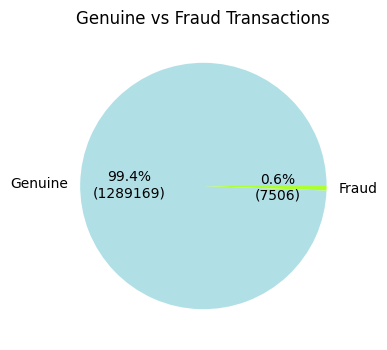

In [161]:
# Count total transactions by fraud status
is_fraud_total_df = (
    analysis_df
        .groupBy('is_fraud')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = is_fraud_total_df.toPandas()

# Define function for setting value display in pie chart
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

# Create the figure
plt.figure(figsize=(4, 4))

# Create the pie chart
plt.pie(
    pandas_df['count'], 
    labels=pandas_df['is_fraud'], 
    colors=['powderblue', 'greenyellow'], 
    autopct=lambda pct: func(pct, pandas_df['count'])
)
plt.title('Genuine vs Fraud Transactions')

# Display the plot
plt.show()

## 10.1 Finding
- The number of fraudulent transactions is a very small proportion (less than 1%) of the total transactions.

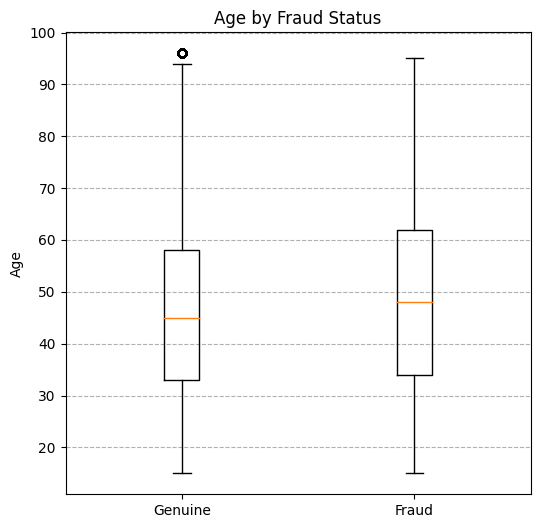

In [178]:
# Get all age and fraud status
age_and_status_df = analysis_df.select('is_fraud', 'age')

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = age_and_status_df.toPandas()

# Split data based on fraud status
fraud_pandas_ages = pandas_df[pandas_df['is_fraud'] == 'Fraud']['age']
genuine_pandas_ages = pandas_df[pandas_df['is_fraud'] == 'Genuine']['age']

# Create the box plot
plt.figure(figsize=(6, 6))
plt.boxplot([genuine_pandas_ages, fraud_pandas_ages], labels=['Genuine', 'Fraud'])
plt.ylabel('Age')
plt.title('Age by Fraud Status')
plt.grid(axis='y', linestyle='--')

# Display the plot
plt.show()

## 10.2 Finding
- The older age group tend to be users of credit cards (expected as total income increases with age).
- The people who tend to fall prey to fraudulent transactions are slightly older than those in genuine transactions.

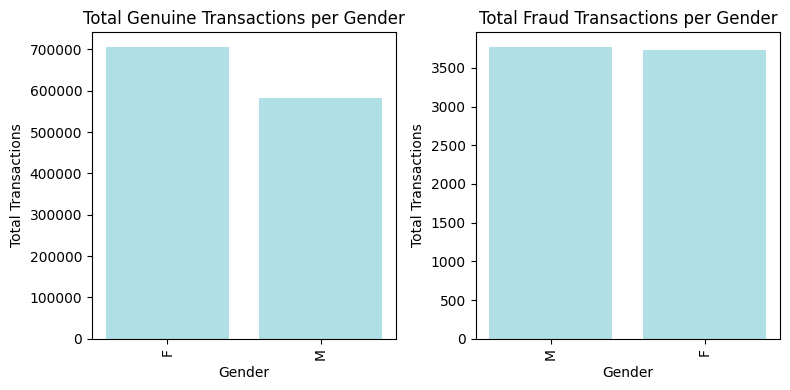

In [190]:
# Count total transactions by fraud status and gender 
gender_total_df = (
    analysis_df
        .groupBy('is_fraud', 'gender')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = gender_total_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud']
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine']

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['gender'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Total Genuine Transactions per Gender')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['gender'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Total Fraud Transactions per Gender')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.3 Finding
- There are more female credit card users than male.
- Both gender fall prey to fraudulent transactions in equal proportions.

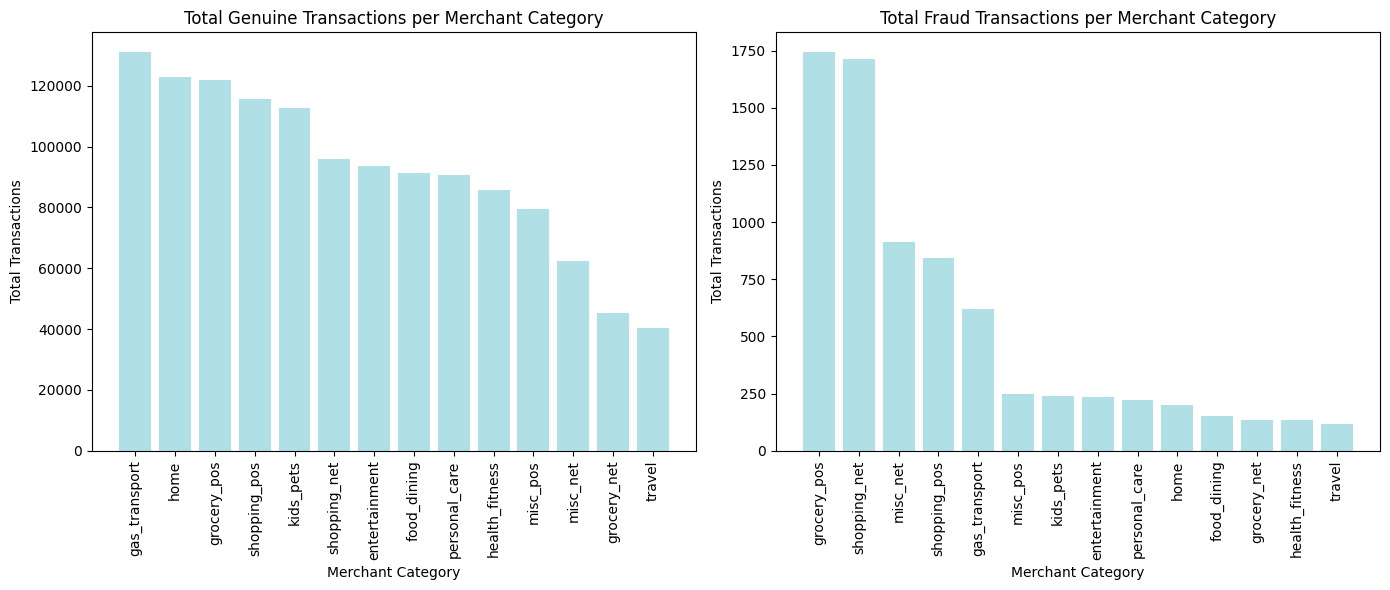

In [169]:
# Count total transactions by fraud status and purchase category 
purchase_total_df = (
    analysis_df
        .groupBy('is_fraud', 'category')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = purchase_total_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='count', ascending=False)
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='count', ascending=False)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['category'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('Merchant Category')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Total Genuine Transactions per Merchant Category')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['category'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('Merchant Category')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Total Fraud Transactions per Merchant Category')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.4 Finding
- Fraud transactions seem to make more purchases on `grocery_pos` and `shopping_net` than other categories.
- This can be used as a good indicator of a fraudulent transaction.

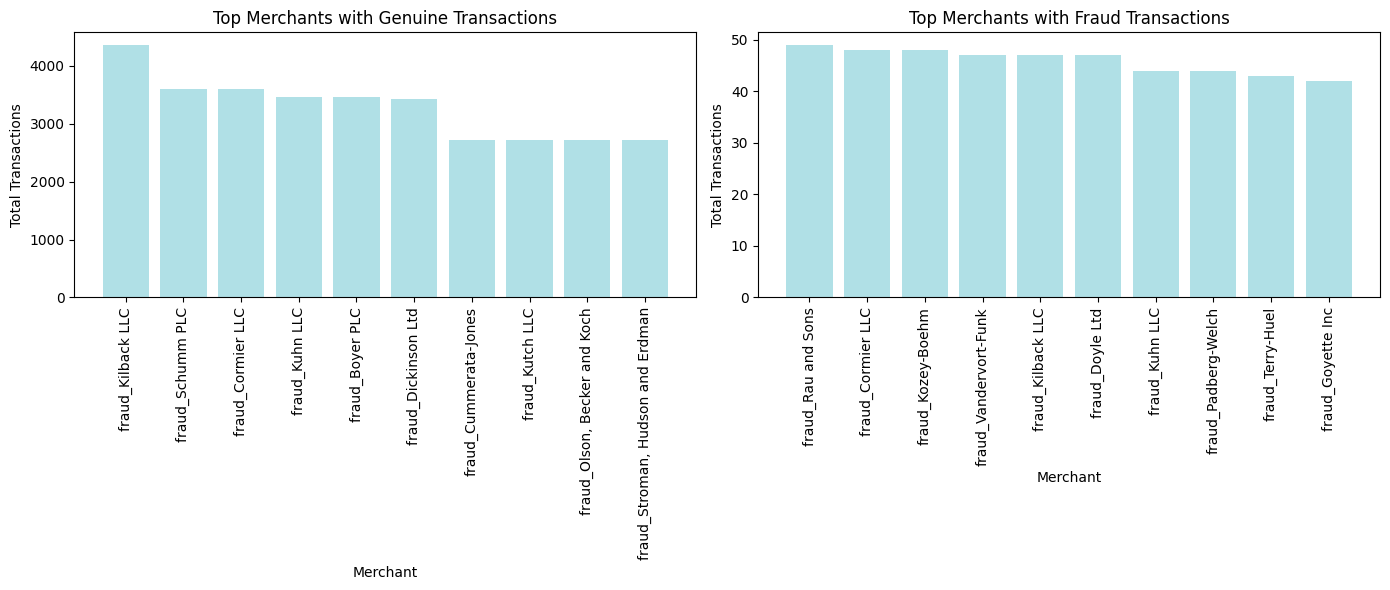

In [198]:
# Count total transactions by fraud status and merchant
merchant_total_df = (
    analysis_df
        .groupBy('is_fraud', 'merchant')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = merchant_total_df.toPandas()

# Split data based on fraud status
# Only take the top 10 merchants for each fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='count', ascending=False)[:10]
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='count', ascending=False)[:10]

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['merchant'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('Merchant')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Top Merchants with Genuine Transactions')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['merchant'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('Merchant')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Top Merchants with Fraud Transactions')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.5 Finding
- There are several merchants in the top merchants in fraudulent transactions that arent in the top merchants in genuine transactions
  - eg. `fraud_Ray and Sons` and `fraud_Kozey_Boehm`
- Could be an indicator of a fraudulent transaction; would need further investigation into merchant.
- Merchant profile can aid in identifying what fraud perpetrators are targeting.

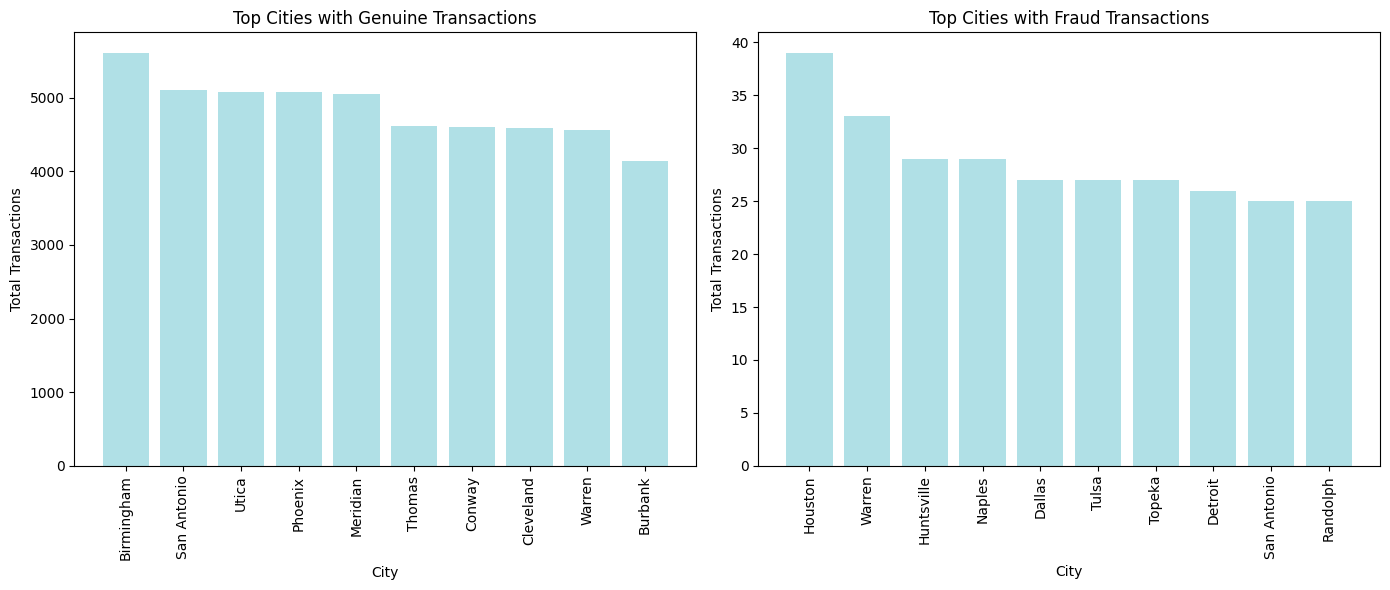

In [199]:
# Count total transactions by fraud status and city
city_total_df = (
    analysis_df
        .groupBy('is_fraud', 'city')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = city_total_df.toPandas()

# Split data based on fraud status
# Only take the top 10 cities for each fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='count', ascending=False)[:10]
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='count', ascending=False)[:10]

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['city'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Top Cities with Genuine Transactions')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['city'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('City')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Top Cities with Fraud Transactions')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.6 Finding 
- The top cities in fraudulent transactions are different from the top cities in genuine transactions.
- This can be used as a good indicator for fraudulent transaction.
- This information can be used to aid further investigation of root cause of fraud.

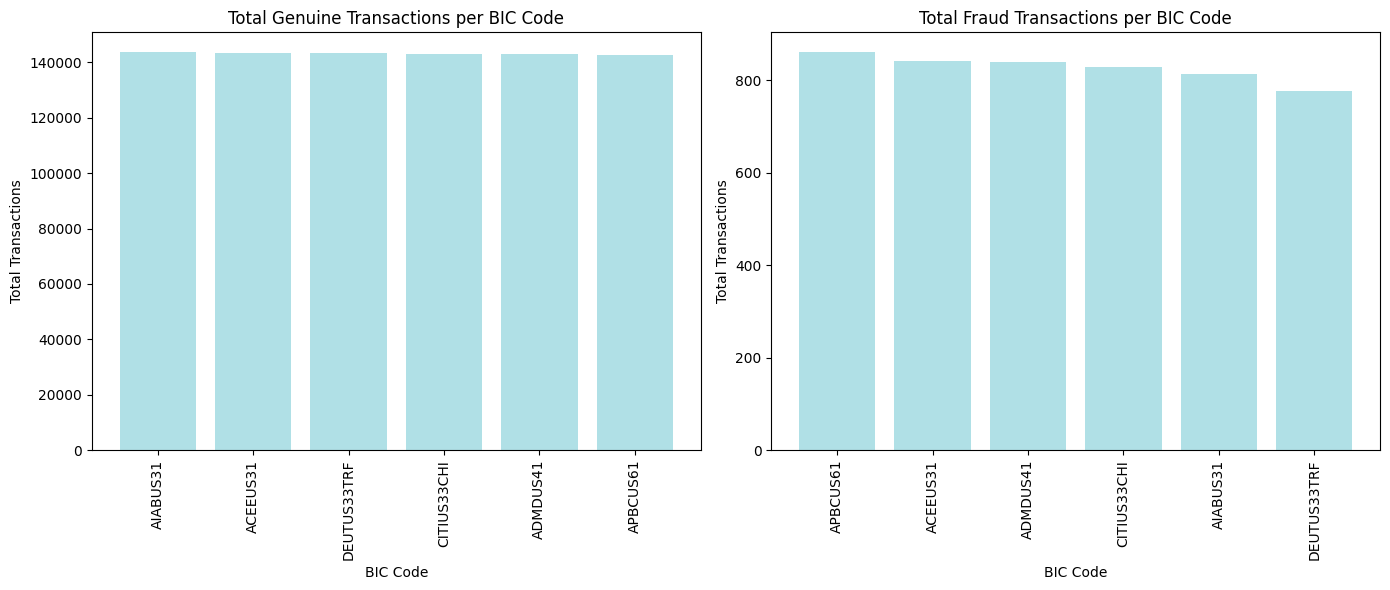

In [201]:
# Count total transactions by fraud status and BIC code
bic_total_df = (
    analysis_df
        .groupBy('is_fraud', 'cc_bic')
        .count()
        .filter(F.col('cc_bic').isNotNull())
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = bic_total_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='count', ascending=False)
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='count', ascending=False)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['cc_bic'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('BIC Code')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Total Genuine Transactions per BIC Code')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['cc_bic'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('BIC Code')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Total Fraud Transactions per BIC Code')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.7 Finding
- All banks involved in the transaction data seem to get hit by fraudulent transactions equally.
- This could indicate a common flaw that exists in the systems of all these banks.
- It could also mean a zero-day attack whereby the vulnerability is still unknown to the banks.

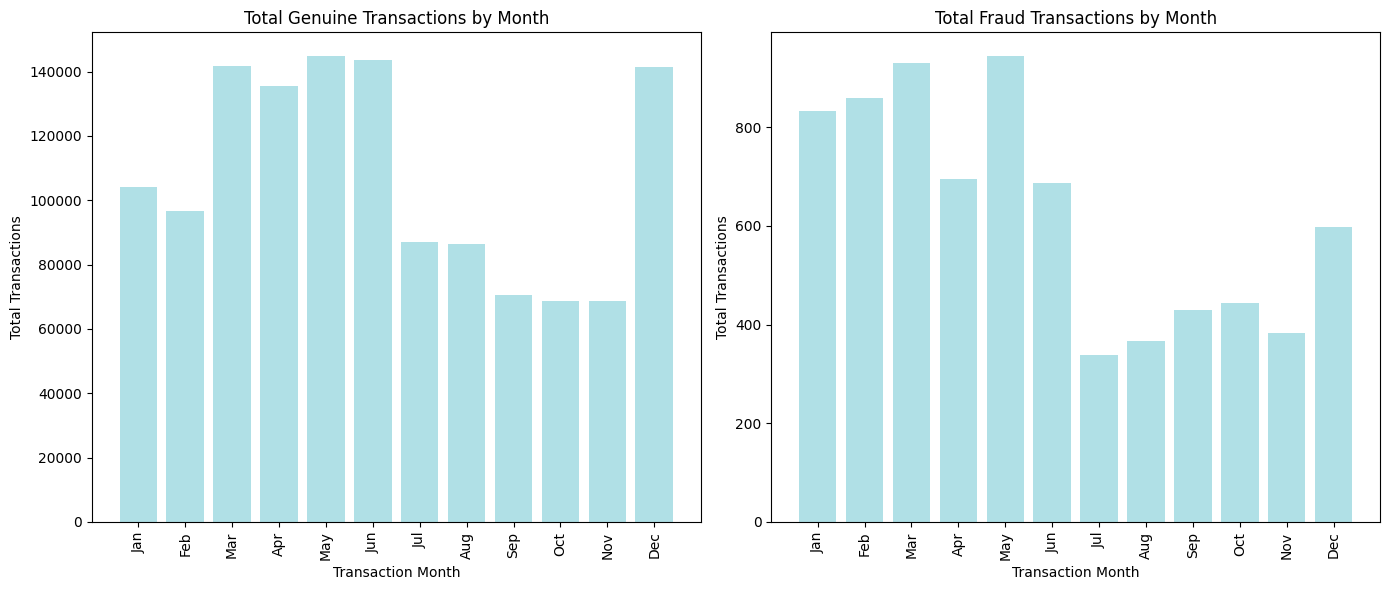

In [191]:
# Count total transactions by fraud status and transaction month 
month_total_df = (
    analysis_df
        .groupBy('is_fraud', 'trans_month', 'trans_month_no')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = month_total_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='trans_month_no')
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='trans_month_no')

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['trans_month'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('Transaction Month')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Total Genuine Transactions by Month')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['trans_month'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('Transaction Month')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Total Fraud Transactions by Month')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.8 Finding
- Fraudulent transactions seem to dominate the first half of the year especially in the first quarter.
- Genuine transactions spikes during the holiday season of `December` and the second quarter.

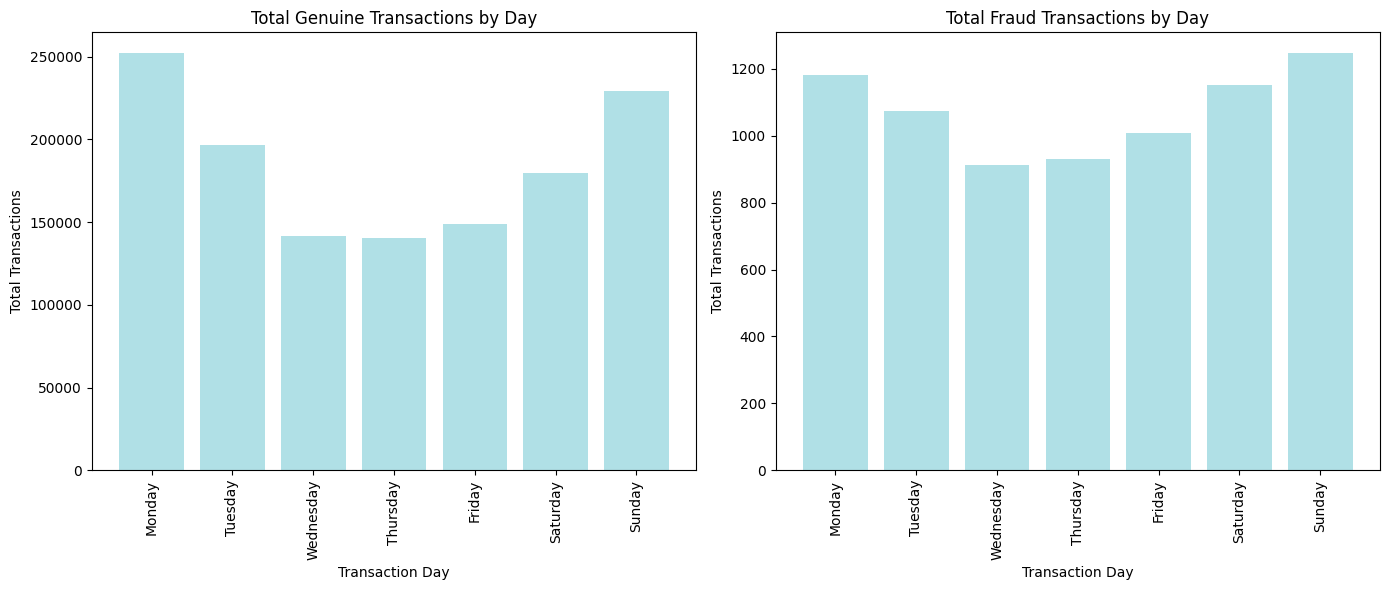

In [192]:
# Count total transactions by fraud status and transaction day 
day_total_df = (
    analysis_df
        .groupBy('is_fraud', 'trans_day', 'trans_day_no')
        .count()
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = day_total_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud'].sort_values(by='trans_day_no')
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine'].sort_values(by='trans_day_no')

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (bar chart)
axes[0].bar(genuine_pandas_df['trans_day'], genuine_pandas_df['count'], color='powderblue')
axes[0].set_xlabel('Transaction Day')
axes[0].set_ylabel('Total Transactions')
axes[0].set_title('Total Genuine Transactions by Day')
axes[0].tick_params(axis='x', rotation=90)

# Second subplot for fraud data (bar chart)
axes[1].bar(fraud_pandas_df['trans_day'], fraud_pandas_df['count'], color='powderblue')
axes[1].set_xlabel('Transaction Day')
axes[1].set_ylabel('Total Transactions')
axes[1].set_title('Total Fraud Transactions by Day')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.9 Finding
- Both types of transactions have the same trend of occuring more at the start and end of the week

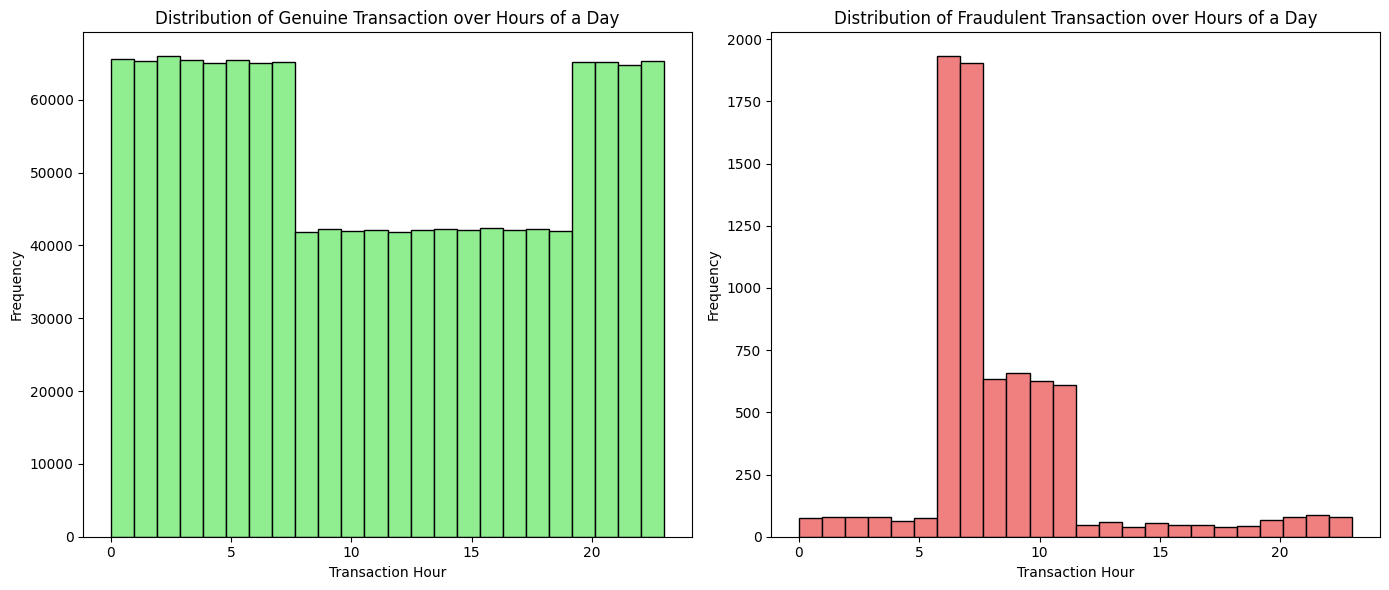

In [224]:
# Get all transaction hour and fraud status 
trans_hour_and_status_df = analysis_df.select('is_fraud', 'trans_hour')

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = trans_hour_and_status_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud']['trans_hour']
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine']['trans_hour']

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (histogram)
axes[0].hist(genuine_pandas_df, bins=24, color='lightgreen', edgecolor='black')
axes[0].set_xlabel('Transaction Hour')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Genuine Transaction over Hours of a Day')

# Second subplot for fraud data (histogram)
axes[1].hist(fraud_pandas_df, bins=24, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Transaction Hour')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Fraudulent Transaction over Hours of a Day')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

## 10.10 Finding
- Transactions usually dip during working hours and spike on after working hours.
- Fraudulent transactions happen during the early morning rush hours and sometimes into the late morning.
- This is a clear sign that fraud perpetrator target times when people are most likely busy and banks have yet to open.
- This can be used as a good indicator of a fraudulent transaction.

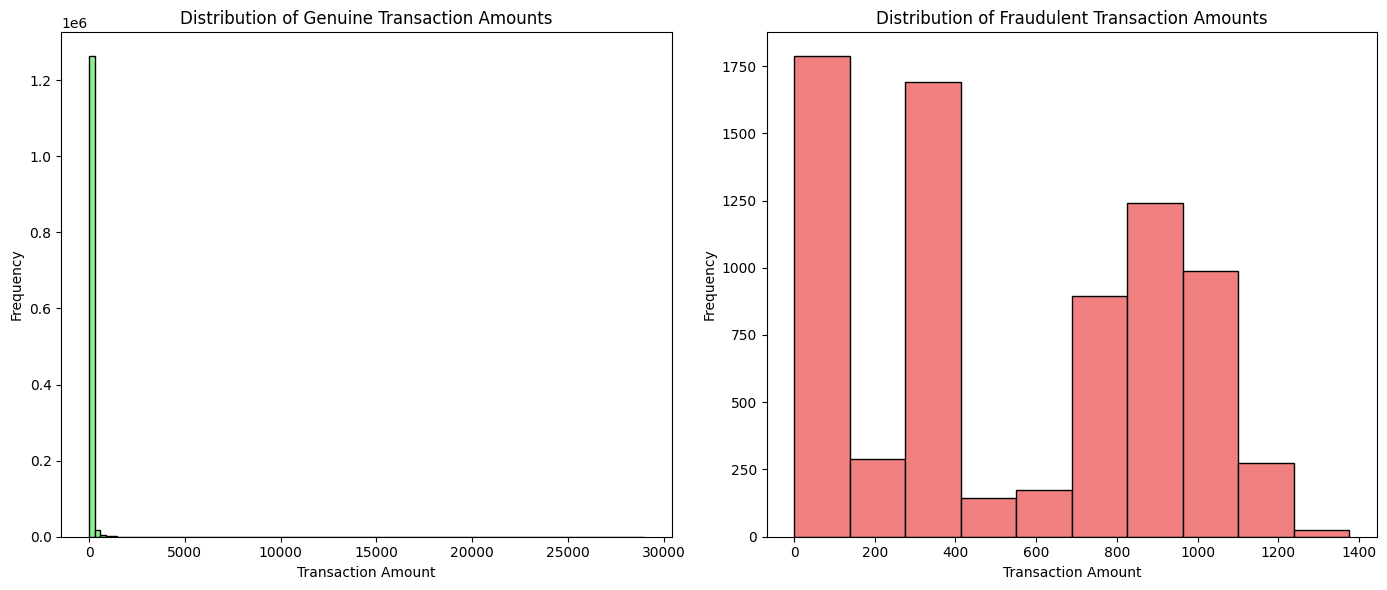

In [205]:
# Get all amount and fraud status 
amt_and_status_df = analysis_df.select('is_fraud', 'amt')

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = amt_and_status_df.toPandas()

# Split data based on fraud status
fraud_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Fraud']['amt']
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine']['amt']

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot for genuine data (histogram)
axes[0].hist(genuine_pandas_df, bins=100, color='lightgreen', edgecolor='black')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Genuine Transaction Amounts')

# Second subplot for fraud data (histogram)
axes[1].hist(fraud_pandas_df, bins=10, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Transaction Amount')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Fraudulent Transaction Amounts')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

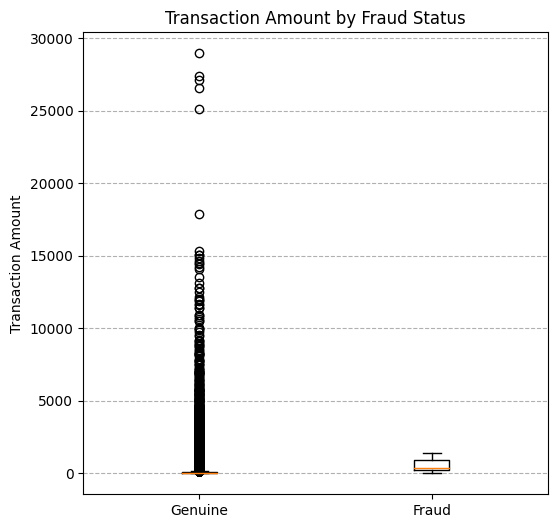

In [206]:
# Get all amount and fraud status 
amt_and_status_df = analysis_df.select('is_fraud', 'amt')

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = amt_and_status_df.toPandas()

# Split data based on fraud status
fraud_pandas_ages = pandas_df[pandas_df['is_fraud'] == 'Fraud']['amt']
genuine_pandas_ages = pandas_df[pandas_df['is_fraud'] == 'Genuine']['amt']

# Create the box plot
plt.figure(figsize=(6, 6))
plt.boxplot([genuine_pandas_ages, fraud_pandas_ages], labels=['Genuine', 'Fraud'])
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount by Fraud Status')
plt.grid(axis='y', linestyle='--')

# Display the plot
plt.show()

## 10.11 Finding
- Fraudulent transactions seem to happen in ranges of amount that might be alarming to a regular person.
  - Below a 100 (to be sneaky)
  - Within 300 to 400 (slightly alarming)
  - Within 800 to 1000 (outright alarming)
- These ranges are understandable as most credit card limits are within those ranges.
- The genuine transaction data has plenty of outliers and would require some cleaning before a pattern can be identifed.

In [218]:
# Get the first quartile and third quartile of the amount field
summary_df = (
    analysis_df
        .select(
            F.percentile_approx('amt', 0.25).alias('Q1'),
            F.percentile_approx('amt', 0.75).alias('Q3')
        )
)

# Retrieve the Q1 and Q3 values from the summary DataFrame
summary_row = summary_df.collect()[0]
q1 = summary_row.Q1
q3 = summary_row.Q3

# Calculate the inter quartile range (IQR)
iqr = q3 - q1

# Define the lower bound for outliers (Q1 - 1.5 * IQR)
lower_bound = q1 - 1.5 * iqr

# Define the upper bound for outliers (Q3 + 1.5 * IQR)
upper_bound = q3 + 1.5 * iqr

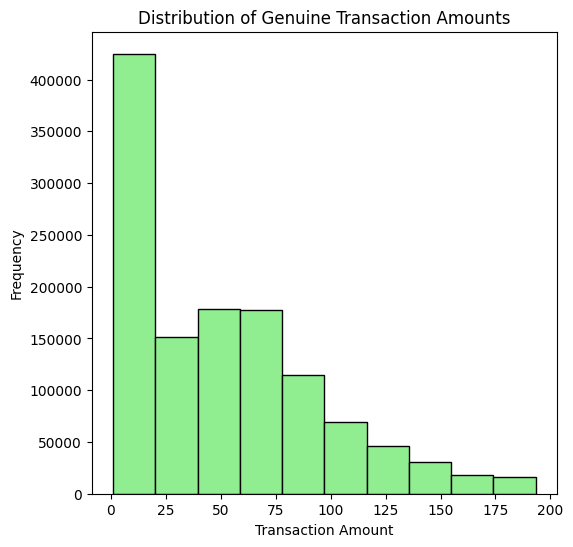

In [220]:
# Get all amount and fraud status 
# Remove upper outliers in amount
cleaned_amt_and_status_df = (
    analysis_df
        .select('is_fraud', 'amt')
        .filter((F.col('amt') >= lower_bound) & (F.col('amt') <= upper_bound))
)

# Convert the aggregated PySpark DataFrame to a Pandas DataFrame
pandas_df = cleaned_amt_and_status_df.toPandas()

# Filter data for genuine status only
genuine_pandas_df = pandas_df[pandas_df['is_fraud'] == 'Genuine']['amt']

# Create the histogram
plt.figure(figsize=(6, 6))
plt.hist(genuine_pandas_df, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Genuine Transaction Amounts')

# Display the plot
plt.show()

## 10.12 Finding
- After removing the outliers from genuine transactions, it is clear that a regular person usually spend below a hundred when using credit card.
- Although large transaction amounts can be genuine, they are not common.
- The transaction amount can therefore be a good indicator of a fraudulent transaction.

# 11. Handle PII Data

## 11.1 Method
- Assumming that the PII data are recoverable for use again, the PII fields will be encrypted using AES encryption.
  - The `aes_encrypt` function expects a binary input field and a binary key
  - The encryption key is expected to be of 16, 24 or 32 characters in length
  - Numerical fields are casted to string and then to binary to preserve their original representation
  - The output of the `aes_encrypt` function is a binary value
  - The `hex` function converts the binary value into a hexadecimal text for easier display in text-based output.
- All fields coming from the `personal_detail` field will be treated as PII fields.
- The `cc_num` and `cc_bic` will be treated as PII fields as well

In [107]:
# List all PII fields
pii_columns = [
    'cc_num', 'cc_bic',
    'first', 'last', 'dob', 'gender', 'job', 
    'lat', 'long', 'street', 'zip', 'city', 'city_pop', 'state',  
]

# Set encryption key and convert to binary
encryption_key_string = 'thisisasecretkey'
encryption_key_bytes = encryption_key_string.encode('utf-8')

# Encrypt each PII field with AES encryption while retaining other non-PII fields
# Use hex function to convert binary value to hexadecimal text
encrypted_columns = [ 
    F.hex(F.aes_encrypt(F.col(column).cast('string').cast('binary'), F.lit(encryption_key_bytes))).alias(column)
    if column in pii_columns
    else F.col(column)
    for column in order_df.columns                               
]

# Get dataframe with encrypted PII fields
encrypted_df = order_df.select(encrypted_columns)

# View encrypted dataframe
encrypted_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 08:00:18,3751653E74B2F82F6472ABEC077FEDF9755D7F83D7025D17A3DBA7D802FAA2D83A78B7D0F5A8939F6D0E1C4E,"fraud_Rippin, Kub and Mann",misc_net,4.97,5B34A9E373723FF143940B31334DBE1180AFEA59DF51394D356F51F1BA405F1A3AE68C94,75E2EB2957AEED4754871E83FDBC0FFDE65DCD790C5F675B5D0209EAB8CAFD3D4B,C991C73DAF4787755481BA7A35DFD55844EE7902B20FA71418ED70EB7C,ED50CC41C7B9B5D28D0A73216866EB3E579FEC81B852BB8A4E60F1B11E91FCE77311F6B2D11A9B563967,DE7FEA211B208CF7F3AEF2D242052705706D0270DDD5B37B09A25933D070C1042ABA5FCFBABA24F6A454,DD9BDF57319AACD0F7067CBD41A3BE7D5ED92ED572CC7EFE5E88B5EA7690,A9D534F5BD6BE2C360C0B0BBE319DF3522006FCAD12CBECDA01E0828C9BF83FD90,CD82EEEBDFDF74C7F87D8E23F22E0BF327864B9908F36FF1262843E4DB79C344026D92,73F84E6ABB6916B40B56BF6EB33EFD56040B55180B5CAD9A7EE46E780E5F8AE3D5E6762F,3331E14511DFE55CBB411BF192400DF14B3E33D46E6AC745BB9CA0E034664CCC,661EC1141E3041D7BA661CA1631511B679D5DD56308893295DE95EDDFB9431716FD41C32161DAD35ADABA83216E3A78F1D06F45A0A,09A7A77B1DA9267712BE5938EB3E9D72D8CD7BDEF9812235663CB9EAE2CF54415DAA73F77397,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18,2012-01-01 08:00:18,A7C0DF9397259CF2EE9B1DF7405A36ECA1502B3633C4DF398A9E6276E3EF1D855A1FB2DF010422
1,1,2019-01-01 08:00:44,8B7329766CFC1291CF57C9717A472424511726AD140EF52A71E010C3052FE414A22AB68A6B480B76,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,8CA32C6F0B79C95CB547EB04F740914F8A19A5AF95D36E0B90E94302ACED4693C97215BD81,22D986D53F521E36FFF6D16B9AFC242ECF589BE7461CA60D69AC89D0EC33C6B8,FE5E10B075554A4BC0D5C231CF5DDD89C2165DD6439A9B4690E776420A,78BA624C0AC0186695403D3ADC019D9E1CDD961DCF63470680E4B1B7E6F9481D4047E6183C91B9E94D9BF8F96CF97C1DF7DC303BE6300BFB,6E139D941316605A44EAF3DB026763960AD3734E20BE27B0DE0682F4DF59033ABB05,2F759D6F8BE3BCA06BFEE549CBFE9EBE63225640BCA2A21C83E6A2E7A87B,2D592A1C0A1D4D439363879B901349786E41A98F460BDB82E1AEA08B527BAC6327,1FA88430164EF5BD73274331FFAF316CECDABD9674061997E1B16914A7E2E65289842E,23D55963EE4DD22FEEE5DA0B733F8263F0A521AF8CB89C3092CFC90EF5E29A8201C150057C,216954A1D4456E88A3790BB4005E46CE2274036ED8DABA50968A7605FDB858,43D7E06FEDA3448FDA360ED0577EB4CC03CE7825AD04924D3459D2C446531685EF2C3495BBCCCAF1F75778314C163C9399AD64841C387206EB78CA3F65,38075A7CAED1315660BBADCAEE83541D811DA395AE5189A4263ED6C9BE887358832FF91B785B,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,None,2012-01-01 08:00:44,2012-01-01 08:00:44,307AC14CF22698A4385C3F74E0492A32A88E45538AA815312741978F843D6940BB4F3215
2,2,2019-01-01 08:00:51,26F8BE7A5BD7B0A258E6C3F74B5CA5C7829067B3AE1DD36D5E32308A1BEC3C45FB1CC6176159C32BCADF,fraud_Lind-Buckridge,entertainment,220.11,0204B0467B4A384C7DAB805B1FCA2A88A09C5E94D977A1BAFB9D483370259F5BB530,378FF149F121203E3C5879CBCCAB7E5D3F01F3D26C6C4289EB4C839D9035944B93460B,D9402FA302BED808C8F6FFD42D275AD2635FD225C3BF7A1A795E971098,98CB2B4774C9CB26F91BF221285600AEC1535F33ACD350E7A884C6E22F437F552699E8052145AA9173E58C11D426325A2794D44B,40C81FBD83881EDDD2C5F817E3E4692FE9F3E28F15373D47969EA4132B548E614CA9BEB9F8B6,54894E27100EB7B09EF0BC1585421C54FB5B857181E556750AE36A1F9CC6,C87B0686E8626C56DA0604A02B4F41C24604FCDF8958A8D2DB3AF4E7731AF78C69,71E6AC1F0FFFF11D24A3494413CD520D43319140C5C58F5F3FCCF7A288C37DA1113DE2,D87A0E8F26FB1EDAA3CBFD526DD5B6E9840DEF8D23F850D8211FFEFEBA90E4AF0A456727,20E274AD5FDD8F6E73F8ED21CC9625A444A5EEAA66CDBEAA464D258E40B17582,2280DD6C206E17DA70C93A7F9301D2914F1413259A5573A28D2DB6D2D386F24372CCF17F417666033D74858691C74E208C8F64BDC56269,ADCEA744730BB75909BE06964BF452F6266102DC837D4EE084AF270C4C2C57D5A26991F66380,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51,2012-01-01 08:00:51,None
3,3,2019-01-01 08:01:16,FF15891F4845C6DB60567236FD315A8F851ADC41EC07031DFF8EF60365A38E4918AD4F1BD4BBE06436FFCFEB,"fraud_Kutch, He

In [111]:
# Decrypt each PII field while retaining other non-PII fields
# Use unhex function to convert hexadecimal text to binary value 
# The same encryption key is used again as its a symmetric encryption
decrypted_columns = [ 
    F.aes_decrypt(F.unhex(F.col(column)), F.lit(encryption_key_bytes)).cast('string').alias(column)
    if column in pii_columns
    else F.col(column)
    for column in order_df.columns                               
]

# Get dataframe with encrypted PII fields
decrypted_df = encrypted_df.select(decrypted_columns)

# View encrypted dataframe
decrypted_df.limit(5).toPandas()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 08:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 08:00:18,2012-01-01 08:00:18,CITIUS33CHI
1,1,2019-01-01 08:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,None,2012-01-01 08:00:44,2012-01-01 08:00:44,ADMDUS41
2,2,2019-01-01 08:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.262,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 08:00:51,2012-01-01 08:00:51,None
3,3,2019-01-01 08:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 08:01:16,2012-01-01 08:01:16,DEUTUS33TRF
4,4,2019-01-01 08:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,2012-01-01 08:03:06,2012-01-01 08:03:06,APBCUS61


## 11.2 Finding
- The encrypted dataframe can later be decrypted by reversing the steps done during encryption.
  - The `unhex` function is first used to convert the hexadecimal text to binary value
  - The `aes_decrypt` still expects a binary input field and the same binary key used in encryption
  - AES encryption is a symmetric encryption that uses the same key to encrypt and decrypt
- After decrypting the PII fields, all the PII fields will be of `string` data type.
  - Appropriate casting should be done on timestamp and numerical fields

# 12. Estimating Nearest Merch Zipcode

## 12.1 Method
- To fill the missing `merch_zipcode`, a reference dataset containing all US zipcodes is used.
  - Link external dataset: `https://simplemaps.com/data/us-zips`
- Retrieve only necessary fields from reference dataset and ensure coordinates are in numerical data type.
- Do checks on the reference dataset to ensure unique zipcodes and coordinates.

In [112]:
# Get reference dataset containing US zipcodes with respective latitude and longtitude 
zip_raw_df = spark.read.csv('/kaggle/input/us-zips/uszips.csv', header=True)

# View raw reference dataset
zip_raw_df.limit(5).toPandas()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,00601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,TRUE,None,16721,100.2,72001,Adjuntas,"""{""""72001"""": 98.74","""""72141"""": 1.26}""",Adjuntas|Utuado,72001|72141,FALSE,FALSE
1,00602,18.36075,-67.17541,Aguada,PR,Puerto Rico,TRUE,None,37510,477.6,72003,Aguada,"""{""""72003"""": 100}""",Aguada,72003,FALSE,FALSE,America/Puerto_Rico
2,00603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,TRUE,None,48317,543.1,72005,Aguadilla,"""{""""72005"""": 99.76","""""72099"""": 0.24}""",Aguadilla|Moca,72005|72099,FALSE,FALSE
3,00606,18.16585,-66.93716,Maricao,PR,Puerto Rico,TRUE,None,5435,47.3,72093,Maricao,"""{""""72093"""": 82.27","""""72153"""": 11.66","""""72121"""": 6.06}""",Maricao|Yauco|Sabana Grande,72093|72153|72121,FALSE
4,00610,18.2911,-67.12243,Anasco,PR,Puerto Rico,TRUE,None,25413,264.4,72011,Añasco,"""{""""72011"""": 96.71","""""72099"""": 2.82","""""72083"""": 0.37","""""72003"""": 0.1}""",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003


In [113]:
# Check schema of raw reference dataset
zip_raw_df.printSchema()

root
 |-- zip: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lng: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- zcta: string (nullable = true)
 |-- parent_zcta: string (nullable = true)
 |-- population: string (nullable = true)
 |-- density: string (nullable = true)
 |-- county_fips: string (nullable = true)
 |-- county_name: string (nullable = true)
 |-- county_weights: string (nullable = true)
 |-- county_names_all: string (nullable = true)
 |-- county_fips_all: string (nullable = true)
 |-- imprecise: string (nullable = true)
 |-- military: string (nullable = true)
 |-- timezone: string (nullable = true)



In [114]:
# Check total rows of raw reference dataset
zip_raw_df.count()

33783

In [115]:
# Process the raw reference dataset
zip_ref_df = (
    zip_raw_df
        # Select fields of interest and rename them
        .select(
            F.col('lat').alias('known_lat'),
            F.col('lng').alias('known_lon'),
            F.col('zip').alias('known_zipcode')
        )
        # Convert the latitude and longtitude to appropriate data type
        .withColumn('known_lat', F.round(F.col('known_lat').cast('double'), 6))
        .withColumn('known_lon', F.round(F.col('known_lon').cast('double'), 6))
)

# View processed reference dataset
zip_ref_df.limit(5).toPandas()

,known_lat,known_lon,known_zipcode
0,18.18027,-66.75266,00601
1,18.36075,-67.17541,00602
2,18.45744,-67.12225,00603
3,18.16585,-66.93716,00606
4,18.29110,-67.12243,00610


In [116]:
# Check for duplicate zip codes in reference dataset
(
    zip_ref_df
        .groupBy('known_zipcode')
        .count()
        .orderBy(F.col('count').desc())
        .limit(5)
        .toPandas()
)

,known_zipcode,count
0,02053,1
1,02090,1
2,03442,1
3,03904,1
4,04438,1


In [117]:
# Check for duplicate combination of latitude and longitude in reference dataset
(
    zip_ref_df
        .groupBy('known_lat', 'known_lon')
        .count()
        .orderBy(F.col('count').desc())
        .limit(5)
        .toPandas()
)

,known_lat,known_lon,count
0,42.09497,-72.48806,1
1,42.05206,-71.84850,1
2,42.26210,-71.80145,1
3,42.06224,-71.07751,1
4,42.36918,-71.24101,1


## 12.2 Method
- The goal is to find the nearest reference coordinates to the merchant coordinates to fill the missing `merch_zipcode`.
- The merchant coordinates are joined with nearby reference coordinates using a bounding box.
  - The bounding box is used to set the range of latitude and longitude
  - This matches merchant coordinates to reference coordinates within the specified range only 
  - This avoids the use of cross join and significantly reduces the number of candidate rows
  - The bounding box size was adjusted until all missing zipcodes are filled
- The Haversine distance is used to calculate shortest distance between two points on a sphere.
- Window function is used to get the nearest reference zipcode for each merchant coordinates.

In [118]:
# Function to calculate Haversine distance 
def haversine_expr(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(F.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = F.sin(dlat / 2)**2 + F.cos(lat1) * F.cos(lat2) * F.sin(dlon / 2)**2
    c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))
    return R * c

In [119]:
# Get unique combinations of latitude and longitude for rows with missing merch zipcodes
missing_zip_df = (
    order_df
        .filter(F.col('merch_zipcode').isNull())
        .select('merch_lat', 'merch_long')
        .distinct()
)

# Define bounding box size in degrees
BOUNDING_BOX_SIZE = 3.0

# Set aliases of dataframe for joins
missing_zip_df = missing_zip_df.alias('miss')
zip_ref_df = zip_ref_df.alias('ref')

# Join missing zipcode dataframe and reference zipcode dataframe
# Using latitude and longitude with bounding box condition
bounded_join_df = (
    missing_zip_df
        .join(
            zip_ref_df,
            (F.col('ref.known_lat').between(F.col('miss.merch_lat') - BOUNDING_BOX_SIZE, F.col('miss.merch_lat') + BOUNDING_BOX_SIZE)) &
            (F.col('ref.known_lon').between(F.col('miss.merch_long') - BOUNDING_BOX_SIZE, F.col('miss.merch_long') + BOUNDING_BOX_SIZE))
        )
)

# Compute distance using Haversine formula
# Between merchant coordinates and reference coordinates
bounded_join_df = (
    bounded_join_df.withColumn(
        'distance',
        haversine_expr(F.col('merch_lat'), F.col('merch_long'), F.col('known_lat'), F.col('known_lon'))
    )
)

# Set the window to group by merchant coordinates and ordering by distance in ascending order
window = Window.partitionBy('merch_lat', 'merch_long').orderBy('distance')

# Get the nearest zipcode for each merchant coordinates 
nearest_zipcode_df = (
    bounded_join_df
        .withColumn('rank', F.row_number().over(window))         # Rank by distance
        .filter(F.col('rank') == 1)                              # Filter the shortest distance
        .select(
            'merch_lat', 
            'merch_long', 
            F.col('known_zipcode').alias('filled_zipcode')       # Nearest zipcode
        )
)

# Fill missing merchant zipcodes
filled_zip_df = (
    order_df
        .join(
            nearest_zipcode_df,
            on=['merch_lat', 'merch_long'],
            how='left'
        )
        .withColumn(
            'merch_zipcode',
            F.when(
                F.col('merch_zipcode').isNull(), 
                F.col('filled_zipcode')
            )
            .otherwise(F.col('merch_zipcode'))
        )
)

In [120]:
# Check if there are any missing merch zipcodes
(
    filled_zip_df
        .filter(F.col('merch_zipcode').isNull())
        .count()
)

0